<a href="https://colab.research.google.com/github/pranay8297/deep-learning-projects/blob/master/restoration_with_gram_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install "torch==1.4" "torchvision==0.5.0" #use the old version

In [17]:
from fastai import *
from fastai.vision import *
from PIL import Image

import random

In [18]:
!pip install ipdb
from ipdb import set_trace as st

In [19]:
path = untar_data(URLs.PETS)
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/test'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/med'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/lower'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [20]:
def crappify(im_path, _, **kwargs):
  image = Image.open(im_path).convert('RGB')
  size, dest = kwargs['size'], kwargs['dest']
  dest.mkdir(exist_ok = True, parents = True)
  targ_sz = resize_to(image, size)
  image = image.resize(targ_sz)
  q = random.randint(40, 60)
  image.save(dest/im_path.name, quality = q)

In [ ]:
#test
il = ImageList.from_folder(path/'images')
crappify(il.items[0], 0, size = 128, dest = path/'test')
(path/'test').ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/test/Sphynx_179.jpg')]

In [21]:
path_lr = path/'lower'
path_mr = path/'med'
path_hr = path/'images'

sizes = [(path_lr, 128), (path_mr, 256)]

for dest, sz in sizes:
  parallel(partial(crappify, size = sz, dest = dest), il.items)

In [22]:
path_lr.ls()[:5], path_mr.ls()[:5]

([PosixPath('/root/.fastai/data/oxford-iiit-pet/lower/Sphynx_179.jpg'),
  PosixPath('/root/.fastai/data/oxford-iiit-pet/lower/basset_hound_84.jpg'),
  PosixPath('/root/.fastai/data/oxford-iiit-pet/lower/shiba_inu_4.jpg'),
  PosixPath('/root/.fastai/data/oxford-iiit-pet/lower/leonberger_1.jpg'),
  PosixPath('/root/.fastai/data/oxford-iiit-pet/lower/Birman_59.jpg')],
 [PosixPath('/root/.fastai/data/oxford-iiit-pet/med/Sphynx_179.jpg'),
  PosixPath('/root/.fastai/data/oxford-iiit-pet/med/basset_hound_84.jpg'),
  PosixPath('/root/.fastai/data/oxford-iiit-pet/med/shiba_inu_4.jpg'),
  PosixPath('/root/.fastai/data/oxford-iiit-pet/med/leonberger_1.jpg'),
  PosixPath('/root/.fastai/data/oxford-iiit-pet/med/Birman_59.jpg')])

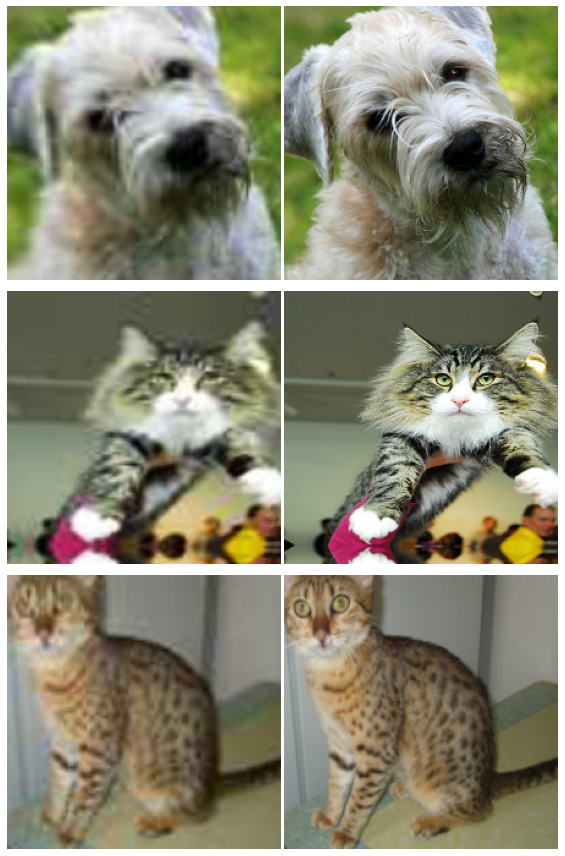

In [23]:
def get_data(path, size, bs):
  src = ImageImageList.from_folder(path).split_by_rand_pct().label_from_func(lambda x: path_hr/x.name)
  return src.transform(get_transforms(max_rotate = 2.0, max_lighting = 0.2), size = size, tfm_y = True).databunch(bs = bs).normalize(imagenet_stats)

data = get_data(path_lr, 224, 8)
data.show_batch(rows = 3)

In [24]:
# PART 2 ------ Loss Function
from torchvision.models import vgg16_bn
vgg = vgg16_bn(True)

In [25]:
#test
for i in vgg.children():
  # print(i)
  pass
layers = vgg.features
# layers
layers[5]

ReLU(inplace=True)

In [26]:
down_idxs = []
for idx, layer in enumerate(layers):
  if isinstance(layer, torch.nn.modules.pooling.MaxPool2d):
    down_idxs.append(idx - 1)
down_idxs

[5, 12, 22, 32, 42]

In [27]:
base_loss = F.l1_loss

In [30]:
#create a Hook Class
class Hook():
  def __init__(self, module):
    self.module = module
    self.stored = None
    self.module.register_forward_hook(self.hook_fn)
  
  def hook_fn(self, module, input, output):
    self.stored = output
  
  def remove(self):
    self.stored = None
    self.module.remove_hook()

In [36]:
#test
x = torch.randn((10, 4, 3, 3))
x.shape

res =x.view(10, 4, -1)
res.shape, res
nres = res.transpose(1, 2)
nres.shape, res.shape
fres = res @ nres
fres.shape

(torch.Size([10, 9, 4]), torch.Size([10, 4, 9]))

In [50]:
#test
print(x.shape)
x.view(20, -1).shape

torch.Size([10, 4, 3, 3])


torch.Size([20, 18])

In [51]:
def get_gram_matrix(acts):
  bs, c, h, w = acts.shape
  return (acts.view(bs, c, h*w) @ acts.view(bs, c, h*w).transpose(1, 2))/(c*h)

In [79]:
class FeatureLoss(nn.Module):
  def __init__(self, down_idxs = down_idxs, layer_wgts = [7., 10., 3., 5., 8.]):
   
    super().__init__()
   
    self.down_idxs = down_idxs
    self.layers = vgg.eval().cuda().features
    self.hooks = [Hook(self.layers[i]) for i in self.down_idxs]
    self.layer_wgts = layer_wgts
    self.base_loss = base_loss
    self.loss_names = ['pixel_loss', 'feat_0', 'feat_1', 'feat_2', 'gram_2','gram_3', 'gram_4']
  
  def get_acts(self):
    return [i.stored for i in self.hooks]
  
  def get_gram_loss(self, acts_yhat, acts_y):
    g_yhat = get_gram_matrix(acts_yhat)
    g_y = get_gram_matrix(acts_y)

    return self.base_loss(g_yhat, g_y)
  
  def forward(self, yhat, y):

    pixel_loss = self.base_loss(yhat, y)
    
    self.layers(y)
    acts_y = self.get_acts()
    self.layers(yhat)
    acts_yhat = self.get_acts()

    feat_losses = [lw*self.base_loss(i, j) for i, j, lw in zip(acts_yhat[:3], acts_y[:3], self.layer_wgts[:3])]
    gram_losses = [lw*self.get_gram_loss(i, j) for i, j, lw in zip(acts_yhat[2:], acts_y[2:], self.layer_wgts[2:])]

    losses = [pixel_loss, *feat_losses, *gram_losses]
    self.metrics = dict(zip(self.loss_names, losses))
    return sum(losses)

In [57]:
for xb, yb in data.train_dl:
  break
xb.shape, yb.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8, 3, 224, 224]))

In [80]:
loss_func = FeatureLoss()
loss = loss_func(xb, yb)
loss

tensor(2.1068, device='cuda:0', grad_fn=<AddBackward0>)

In [81]:
gc.collect()

684

In [82]:
arch = models.resnet34
learn = unet_learner(data, arch, loss_func = loss_func)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


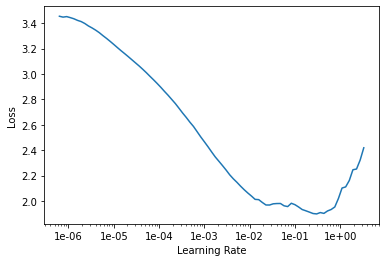

In [83]:
learn.lr_find()
learn.recorder.plot()

In [84]:
learn.fit_one_cycle(5, slice(1e-03), wd = 1e-03)

epoch,train_loss,valid_loss,time
0,0.715074,0.708176,02:43
1,0.667264,0.662394,02:42
2,0.641311,0.642091,02:42
3,0.636519,0.633083,02:42
4,0.635437,0.628682,02:42


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


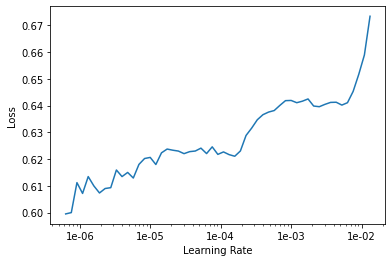

In [85]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [86]:
learn.fit_one_cycle(10, slice (1e-04))

epoch,train_loss,valid_loss,time
0,0.616887,0.628678,02:47
1,0.640447,0.627976,02:47
2,0.623473,0.627748,02:47
3,0.625969,0.625721,02:47
4,0.635285,0.625237,02:47
5,0.614360,0.624337,02:47
6,0.612764,0.622427,02:47
7,0.621328,0.622145,02:48
8,0.623407,0.621770,02:48
9,0.614617,0.622196,02:48


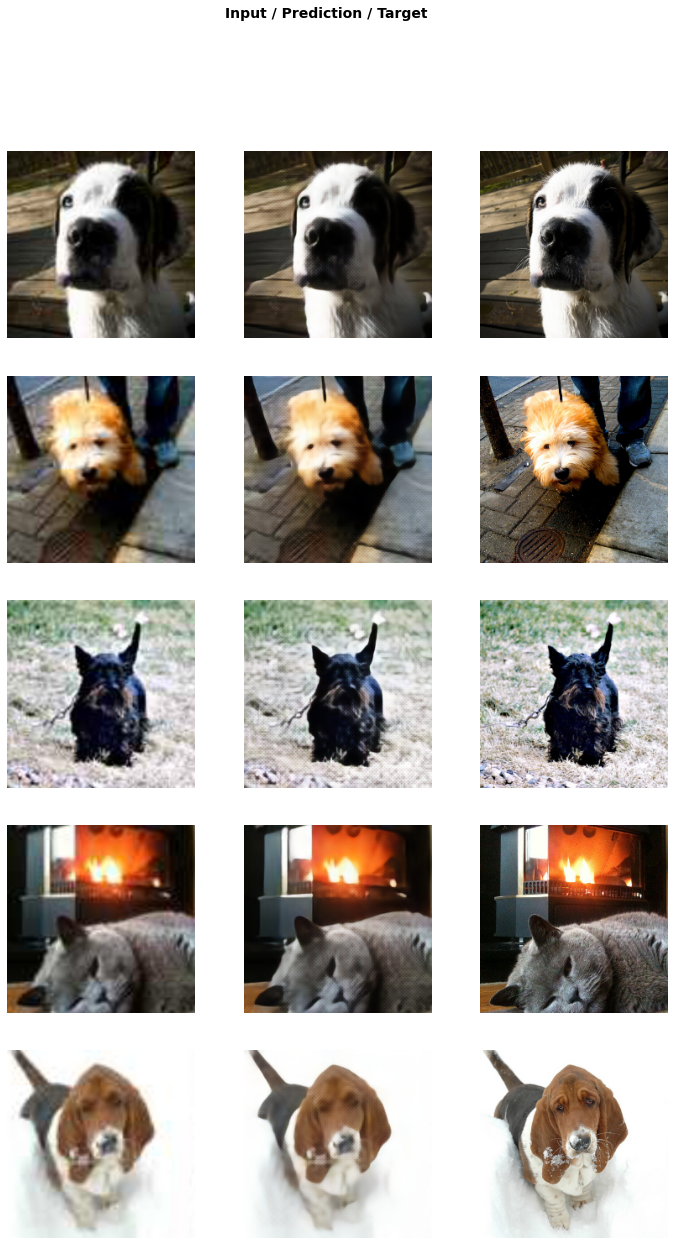

In [87]:
learn.show_results()

In [88]:
xb.shape, yb.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8, 3, 224, 224]))

In [89]:
learn.save('stage-1')

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


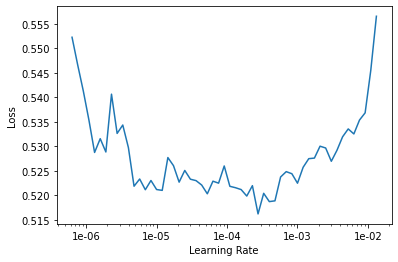

In [90]:
data = get_data(path_mr, 224, 4)
learn.data = data
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [91]:
learn.fit_one_cycle(5, slice(2e-04))

epoch,train_loss,valid_loss,time
0,0.477915,0.482028,03:06
1,0.469084,0.478546,03:04
2,0.463746,0.473808,03:05
3,0.461804,0.470665,03:05
4,0.460601,0.469194,03:05


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


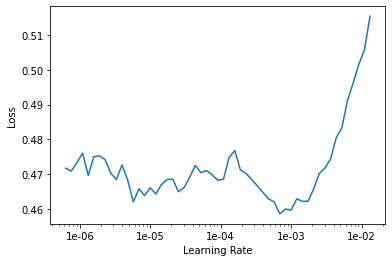

In [92]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [93]:
learn.fit_one_cycle(10, slice(1e-04))

epoch,train_loss,valid_loss,time
0,0.464735,0.469725,03:15
1,0.474397,0.469853,03:14
2,0.463437,0.468336,03:14
3,0.463903,0.469929,03:14
4,0.464729,0.467247,03:14
5,0.461752,0.466658,03:13
6,0.469526,0.466597,03:14
7,0.447061,0.464355,03:14
8,0.460422,0.464743,03:14
9,0.460373,0.464331,03:15


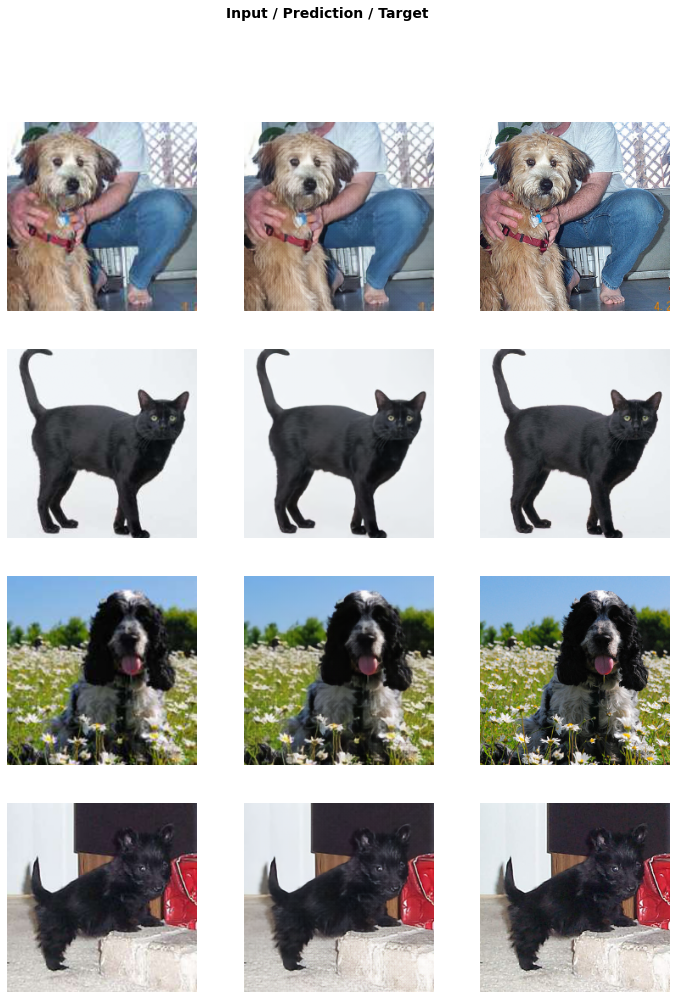

In [94]:
learn.show_results()